In [2]:
import pandas as pd
import geopandas as gd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import rasterio
import rasterio.warp
from rasterio import features
import shapely.geometry
import shapely
import seaborn as sn

In [3]:
os.chdir('/projects/canis/eoc_feature_corr')

In [4]:
grid_path = "./data/ok_pan_coverage.shp"
grid = gd.read_file(grid_path)
grid = grid.set_index('id')

In [5]:
original_feature_path = './data/cover/NLCD_2016_Land_Cover_L48_20190424_IGrpwzCAkFkyZtKBIu8z.tiff'

feature_file = rasterio.open(original_feature_path)
feature_raster = feature_file.read(1)

In [6]:
dst_crs = rasterio.crs.CRS.from_epsg(3857)

In [7]:
transform, width, height = rasterio.warp.calculate_default_transform(
    feature_file.crs, dst_crs, feature_file.width,
    feature_file.height, *feature_file.bounds)
kwargs = feature_file.meta.copy()
kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

dst = './data/cover/NLCD_2016_Land_Cover_L48_20190424_3857.tiff'

with rasterio.open(dst, 'w', **kwargs) as dst:
    rasterio.warp.reproject(
        source=rasterio.band(feature_file, 1),
        destination=rasterio.band(dst, 1),
        src_transform=feature_file.transform,
        src_crs=feature_file.crs,
        dst_transform=transform,
        dst_crs=dst_crs,
        resampling=rasterio.warp.Resampling.nearest)

In [8]:
feature_path = './data/cover/NLCD_2016_Land_Cover_L48_20190424_3857.tiff'

feature_file = rasterio.open(feature_path)
feature_raster = feature_file.read(1)

In [9]:
feature_legend_path = './data/cover/NLCD_landcover_legend_2018_12_17_IGrpwzCAkFkyZtKBIu8z.csv'
feature_legend = pd.read_csv(feature_legend_path)
feature_legend = feature_legend.set_index('Value')
feature_legend = feature_legend.dropna()

In [10]:
feature_legend

,Legend
Value,
0,Unclassified
11,Open Water
12,Perennial Snow/Ice
21,"Developed, Open Space"
22,"Developed, Low Intensity"
23,"Developed, Medium Intensity"
24,"Developed, High Intensity"
31,Barren Land
41,Deciduous Forest


In [11]:
grid['centroid'] = grid['geometry'].centroid
grid = grid.set_geometry('centroid')
grid['feature'] = grid['centroid'].map(lambda coords: next(feature_file.sample(coords.coords, indexes=1))[0])
grid = grid.set_geometry('geometry')
grid = grid.drop('centroid', axis=1)
grid

,left,top,right,bottom,med_rxpwr,chg_covera,verizon_co,geometry,feature
id,,,,,,,,,
27.0,-1.146618e+07,4.413429e+06,-1.146518e+07,4.412429e+06,-120.000,0,1,"POLYGON ((-11466176.166 4413429.055, -11465176...",52
28.0,-1.146618e+07,4.412429e+06,-1.146518e+07,4.411429e+06,-120.000,0,1,"POLYGON ((-11466176.166 4412429.055, -11465176...",52
29.0,-1.146618e+07,4.411429e+06,-1.146518e+07,4.410429e+06,-120.000,0,1,"POLYGON ((-11466176.166 4411429.055, -11465176...",52
30.0,-1.146618e+07,4.410429e+06,-1.146518e+07,4.409429e+06,-120.000,0,1,"POLYGON ((-11466176.166 4410429.055, -11465176...",71
31.0,-1.146618e+07,4.409429e+06,-1.146518e+07,4.408429e+06,-120.000,0,1,"POLYGON ((-11466176.166 4409429.055, -11465176...",71
...,...,...,...,...,...,...,...,...,...
23376.0,-1.113318e+07,4.374429e+06,-1.113218e+07,4.373429e+06,-106.920,1,1,"POLYGON ((-11133176.166 4374429.055, -11132176...",71
23377.0,-1.113318e+07,4.373429e+06,-1.113218e+07,4.372429e+06,-109.290,1,1,"POLYGON ((-11133176.166 4373429.055, -11132176...",21
23378.0,-1.113318e+07,4.372429e+06,-1.113218e+07,4.371429e+06,-107.125,1,1,"POLYGON ((-11133176.166 4372429.055, -11132176...",21


In [12]:
grid = grid.join(feature_legend, how="left", on='feature')

In [13]:
grid['agreement'] = grid['chg_covera'] == grid['verizon_co']

In [15]:
sn.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

In [16]:
confusion_matrix = pd.crosstab( grid['Legend'],grid['agreement'], rownames=['Cover Type'], colnames=['Agreement'], normalize='index')
print (confusion_matrix)

Agreement                         False     True 
Cover Type                                       
Barren Land                    0.615385  0.384615
Cultivated Crops               0.801968  0.198032
Deciduous Forest               0.000000  1.000000
Developed, Low Intensity       0.604167  0.395833
Developed, Medium Intensity    0.250000  0.750000
Developed, Open Space          0.764341  0.235659
Emergent Herbaceuous Wetlands  0.659091  0.340909
Evergreen Forest               0.000000  1.000000
Hay/Pasture                    0.857143  0.142857
Herbaceuous                    0.793719  0.206281
Open Water                     0.727273  0.272727
Shrub/Scrub                    0.733933  0.266067
Woody Wetlands                 0.750000  0.250000


In [17]:
confusion_matrix['Total'] = grid.groupby('Legend').count()['agreement']

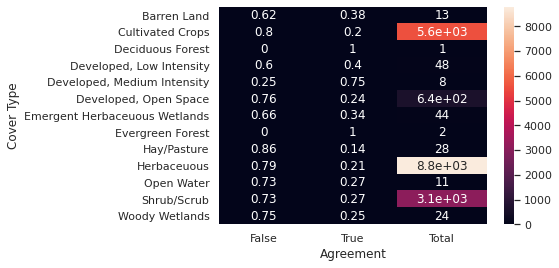

In [18]:
sn.heatmap(confusion_matrix, annot=True)
plt.show()

Agreement                      False  True    All
Cover Type                                       
Barren Land                        8     5     13
Cultivated Crops                4483  1107   5590
Deciduous Forest                   0     1      1
Developed, Low Intensity          29    19     48
Developed, Medium Intensity        2     6      8
Developed, Open Space            493   152    645
Emergent Herbaceuous Wetlands     29    15     44
Evergreen Forest                   0     2      2
Hay/Pasture                       24     4     28
Herbaceuous                     6976  1813   8789
Open Water                         8     3     11
Shrub/Scrub                     2284   828   3112
Woody Wetlands                    18     6     24
All                            14354  3961  18315


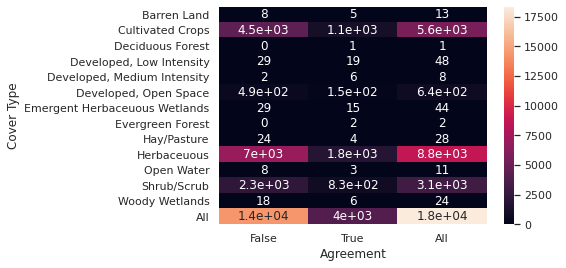

In [85]:
confusion_matrix = pd.crosstab( grid['Legend'],grid['agreement'], rownames=['Cover Type'], colnames=['Agreement'], margins=True)
print (confusion_matrix)
sn.heatmap(confusion_matrix, annot=True)
plt.show()